1. Выберите наборы данных. которые можно интерпретировать, как временные ряды:

а) зависимость цены на недвижимость в конкретном регионе от времени,

б) скорость полета самолета при перелете из аэропорта А в аэропорт В,

в) количество отказов компьютера,

г) число обращений в поликлинику по району,

д) координаты автобуса при движении по маршруту,

е) координаты фигуры нарушителя в файле видеофиксации охранной системы.



Ответ:

       а, б,

       в (если отказы указаны по определенным отрезкам времени(например, неделям)),
       
       г, д,
       
       е(если координаты указаны в динамике с временной меткой)

2.  Прочитайте DUQ_hourly.csv и проверьте качество и порядок разметки этой выборки с информацией о потреблении энергии в одном из районов Восточной Электросети США. Сделайте описание особенностей этой выборки.


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np 
import pandas as pd 
import seaborn as sns

from sklearn.metrics import mean_squared_error

import os

In [2]:
data = pd.read_csv('DUQ_hourly.csv', index_col=[0], parse_dates=[0])

In [3]:
data.head()

,DUQ_MW
Datetime,
2005-12-31 01:00:00,1458.0
2005-12-31 02:00:00,1377.0
2005-12-31 03:00:00,1351.0
2005-12-31 04:00:00,1336.0
2005-12-31 05:00:00,1356.0


### Очистка и проверка 

* Посмотрим на тип данных. 
* Проверим пропуски


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 119068 entries, 2005-12-31 01:00:00 to 2018-01-02 00:00:00
Data columns (total 1 columns):
DUQ_MW    119068 non-null float64
dtypes: float64(1)
memory usage: 1.8 MB


Результат анализа типов показывает, что интервал изменения индексов начинается от 2005-12-31 01:00:00 и идет до 2018-01-02 00:00:00. Мы знаем из описания, что шаг измерений по времени составляет 1 час. Общий объем данных составляет 119068 значений, а тип измеряемой информации при записи был определен как float64.

Посмотрим сразу на характеристики нашего временного ряда в смысле основных статистик (используем pd.describe())

In [5]:
data.describe()

,DUQ_MW
count,119068.000000
mean,1658.820296
std,301.740640
min,1014.000000
25%,1444.000000
50%,1630.000000
75%,1819.000000
max,3054.000000


Или можем посмотреть на это с точки зрения графической модели основных статистик. Однако, необходимо помнить, что в случае временного ряда это не совсем корректное исследование, т.к. существование цикличности и тренда приводят к существенному изменению значений ряда во времени.

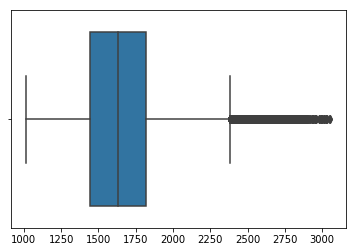

In [6]:
sns.boxplot(data.values)

Сделаем анализ пропусков как определение числа меток с отсутствующим (null) значением.

In [7]:
# проверим пропуски
data['DUQ_MW'].isnull().sum()

0

Очевидно, что нам повезло и просто пропусков нет.

Давайте посмотрим , наконец, как выглядит наш ряд на графике. Отобразим измерения точками '.' c легендой и размером графика (15, 7) 

Text(0, 0.5, 'МВт')

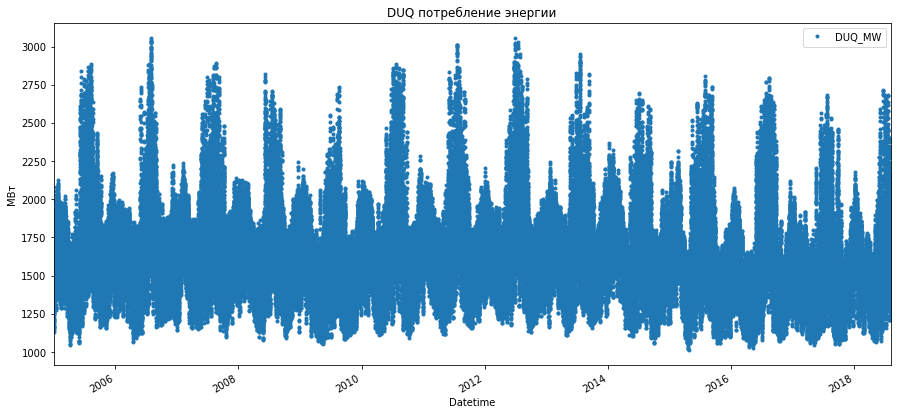

In [8]:
data.plot( style = '.', figsize = ( 15, 7 ), title = 'DUQ потребление энергии' )
plt.ylabel ( 'МВт' )

Рис.1 потребление энергии за весь период ряда

### Обсуждение визуализации

- Основные статистики показали, что пропусков нет
- Визуальный анализ показывает что:
    - Предъявленные данные имеют циклы
    Добавим колонку с датой data['date'] = data.index.

In [9]:
data['date'] = data.index

Рис.2 потребление энергии за 12 дней

In [10]:
import pandas_profiling

In [11]:
pandas_profiling.ProfileReport(data)

Поскольку данные лежат в диапазоне от 1014МВт до 3054, то очевидно, что точность представления float64 избыточна. Перейдем к целым. Это позволит сократить объем занимаемой памяти.

In [12]:
# Теперь целые
data['DUQ_MW'] = data['DUQ_MW'].astype('int')
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 119068 entries, 2005-12-31 01:00:00 to 2018-01-02 00:00:00
Data columns (total 2 columns):
DUQ_MW    119068 non-null int32
date      119068 non-null datetime64[ns]
dtypes: datetime64[ns](1), int32(1)
memory usage: 2.3 MB


Энергия имеет выраженный порядок смены сезонов (рис.1) и дня и ночи (рис.2). 

Пропусков в последовательности нет.

В рассматриваемом ряду "Потребление энергии" число уникальных индексов DatetimeIndex также меньше числа наблюдений-строк.

Попробуем разобраться, что произошло. Добавим индекс как отдельную колонку. Исходная индексация по времени поддерживается объектом DatetimeIndex. Просто создадим новый столбец.

In [13]:
data['date'] = data.index
data.head()

,DUQ_MW,date
Datetime,,
2005-12-31 01:00:00,1458,2005-12-31 01:00:00
2005-12-31 02:00:00,1377,2005-12-31 02:00:00
2005-12-31 03:00:00,1351,2005-12-31 03:00:00
2005-12-31 04:00:00,1336,2005-12-31 04:00:00
2005-12-31 05:00:00,1356,2005-12-31 05:00:00


In [14]:
ut = data['date'].unique()
print('число уникальных значений:   ',ut.shape[0],' : число наблюдений : ', data.shape[0])

число уникальных значений:    119064  : число наблюдений :  119068


Теперь посчитаем уникальные значения в data для колонки 'data'

In [15]:
count_data = data['date'].value_counts()
count_data.head()

2017-11-05 02:00:00    2
2014-11-02 02:00:00    2
2015-11-01 02:00:00    2
2016-11-06 02:00:00    2
2007-07-15 10:00:00    1
Name: date, dtype: int64

Видно, что 4 года подряд в начале ноября однажды вносили данные за день 2 раза. Это очевидно, не верно. Что происходило, следует уточнять у автора данных. В качестве предположения можно подумать о вариантах, например, переход на зимнее время и тогда, в марте -апреле должен быть пропуск. Проверим март-апрель 2015 года

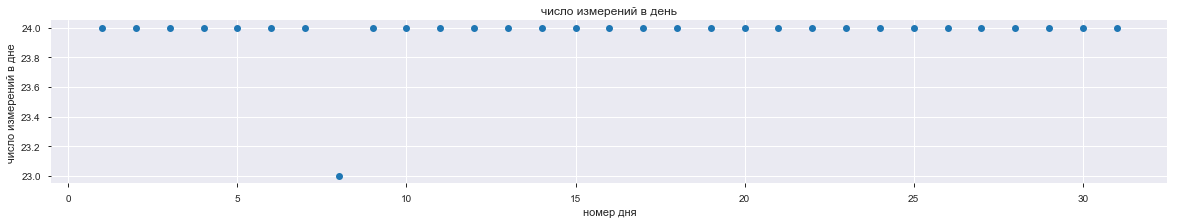

In [16]:
day_H=data['2015-03-01 00:00:00':'2015-03-31 23:00:00'].index.day

plt.figure(figsize=(20,3))
plt.plot(day_H.value_counts().index, day_H.value_counts().values ,'o')

plt.xlabel('номер дня')
plt.ylabel('число измерений в дне')
plt.title('число измерений в день')
plt.show()

Видим, что один из дней марта имеет меньше измерений, чем остальные. Определим номер этого дня используя подсчет числа измерений по дням и сравнение этой цифры с идеальным значением 24.

In [17]:
Day_count = day_H.value_counts() 
Day_count[Day_count != 24]

8    23
Name: Datetime, dtype: int64

Посмотрим на этот день поближе. После 2-го часа сразу наступил 4-й.

In [18]:
data['2015-03-08 01:00:00':'2015-03-08 06:00:00'].index

DatetimeIndex(['2015-03-08 01:00:00', '2015-03-08 02:00:00',
               '2015-03-08 04:00:00', '2015-03-08 05:00:00',
               '2015-03-08 06:00:00'],
              dtype='datetime64[ns]', name='Datetime', freq=None)

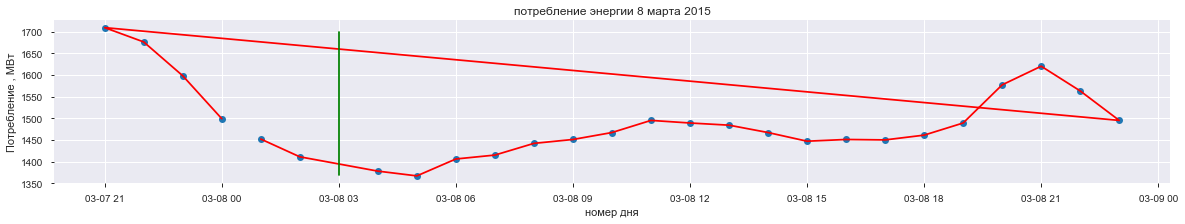

In [23]:
plt.figure(figsize=(20,3))
plt.plot(data['2015-03-07 21:00:00':'2015-03-8 23:00:00'].index,data['2015-03-07 21:00:00':'2015-03-08 23:00:00']['DUQ_MW'].values, 'o')
plt.plot(data['2015-03-07 21:00:00':'2015-03-8 23:00:00'].index,data['2015-03-07 21:00:00':'2015-03-08 23:00:00']['DUQ_MW'].values, 'r')
line_ = pd.to_datetime(pd.Series(['2015-03-08 03:00:00', '2015-03-08 03:00:00']))
plt.plot(line_,np.array([1370,1700]),'g')
plt.xlabel('номер дня')
plt.ylabel('Потребление , МВт')
plt.title('потребление энергии 8 марта 2015')

plt.show()

Рис. 4

Такой день в марте один - 8 марта 2015 :) . Гипотезу о переходе на летнее(зимнее) время можно считать доказанной. Найдем все такие аномалии по всему ряду.

выдвинутую гипотезу можно считать подтвержденной, т.к. очевидно, что есть разрыв в индексах. Эти разрывы необходимо пометить и преобразовать, пользуясь какой-либо общей идеей.

In [24]:
day_H=data['2014-03-01 00:00:00':'2014-03-31 23:00:00'].index.day

Day_count = day_H.value_counts() 
d2014 = Day_count[Day_count != 24].index
d2014

Int64Index([9], dtype='int64')

In [25]:
day_H=data['2015-03-01 00:00:00':'2015-03-31 23:00:00'].index.day

Day_count = day_H.value_counts() 
d2015 =Day_count[Day_count != 24].index
d2015

Int64Index([8], dtype='int64')

In [26]:
day_H=data['2016-03-01 00:00:00':'2016-03-31 23:00:00'].index.day

Day_count = day_H.value_counts() 
d2016 =Day_count[Day_count != 24].index
d2016

Int64Index([13], dtype='int64')

In [27]:
day_H=data['2017-03-01 00:00:00':'2017-03-31 23:00:00'].index.day

Day_count = day_H.value_counts() 
d2017 =Day_count[Day_count != 24].index
d2017

Int64Index([12], dtype='int64')

Попробуем решить проблему пропуска. Построим пропуск как интерполяцию между соседними метками. Поскольку наше измерение является "фейком", то его назначение должно быть обосновано характером ряда и его типовым поведением. Наш ряд имеет гладкий характер в часовых диапазонах. Построим пропуск как среднее по 2-м соседям. Больше информации о заполнении пробелов во временных рядах можно посмотреть в (https://cyberleninka.ru/article/v/analiz-metodov-zapolneniya-propuskov-vo-vremennyh-ryadah-pokazateley-finansovyh-rynkov). Итак обработаем пропуски.


In [28]:
v1 = list((data['2014-03-09 02:00:00']['DUQ_MW'].values + data['2014-03-09 04:00:00']['DUQ_MW'].values) / 2)
print(v1)
v2 = list((data['2015-03-08 02:00:00']['DUQ_MW'].values + data['2015-03-08 04:00:00']['DUQ_MW'].values) / 2)
v3 = list((data['2016-03-13 02:00:00']['DUQ_MW'].values + data['2016-03-13 04:00:00']['DUQ_MW'].values) / 2)
v4 = list((data['2017-03-12 02:00:00']['DUQ_MW'].values + data['2017-03-12 04:00:00']['DUQ_MW'].values) / 2)
v =np.reshape([v1[0],v2[0],v3[0],v4[0]],(4,1))
v

df_data = pd.DataFrame(index = pd.to_datetime(pd.Series(['2014-03-09 03:00:00','2015-03-08 03:00:00','2016-03-13 03:00:00','2017-03-12 03:00:00'])), columns =['DUQ_MW'] , data = v) 
df_data['date'] = df_data.index
df_data.head()
#
data = data.append(df_data,sort = False)
data.tail()
#data['2014-03-09 03:00:00'] 

[1415.0]


,DUQ_MW,date
2018-01-02 00:00:00,1721.0,2018-01-02 00:00:00
2014-03-09 03:00:00,1415.0,2014-03-09 03:00:00
2015-03-08 03:00:00,1394.5,2015-03-08 03:00:00
2016-03-13 03:00:00,1111.5,2016-03-13 03:00:00
2017-03-12 03:00:00,1454.0,2017-03-12 03:00:00


Уберем лишние точки (дублирование метки в индексах)

In [29]:
count_data.iloc[:4]

2017-11-05 02:00:00    2
2014-11-02 02:00:00    2
2015-11-01 02:00:00    2
2016-11-06 02:00:00    2
Name: date, dtype: int64

In [30]:
data.loc[count_data.iloc[:4].index]

,DUQ_MW,date
2017-11-05 02:00:00,1131.0,2017-11-05 02:00:00
2017-11-05 02:00:00,1105.0,2017-11-05 02:00:00
2014-11-02 02:00:00,1272.0,2014-11-02 02:00:00
2014-11-02 02:00:00,1240.0,2014-11-02 02:00:00
2015-11-01 02:00:00,1113.0,2015-11-01 02:00:00
2015-11-01 02:00:00,1138.0,2015-11-01 02:00:00
2016-11-06 02:00:00,1121.0,2016-11-06 02:00:00
2016-11-06 02:00:00,1107.0,2016-11-06 02:00:00


In [31]:
df = data.loc[count_data.iloc[:4].index]
df_ = df.groupby('date').mean()
df_['date'] = df_.index
print(df_)
print(df)
data.drop(count_data.iloc[:4].index)
data.shape

                     DUQ_MW                date
date                                           
2014-11-02 02:00:00  1256.0 2014-11-02 02:00:00
2015-11-01 02:00:00  1125.5 2015-11-01 02:00:00
2016-11-06 02:00:00  1114.0 2016-11-06 02:00:00
2017-11-05 02:00:00  1118.0 2017-11-05 02:00:00
                     DUQ_MW                date
2017-11-05 02:00:00  1131.0 2017-11-05 02:00:00
2017-11-05 02:00:00  1105.0 2017-11-05 02:00:00
2014-11-02 02:00:00  1272.0 2014-11-02 02:00:00
2014-11-02 02:00:00  1240.0 2014-11-02 02:00:00
2015-11-01 02:00:00  1113.0 2015-11-01 02:00:00
2015-11-01 02:00:00  1138.0 2015-11-01 02:00:00
2016-11-06 02:00:00  1121.0 2016-11-06 02:00:00
2016-11-06 02:00:00  1107.0 2016-11-06 02:00:00


(119072, 2)

Удалим дубликаты

In [32]:
data.drop_duplicates()
data.shape

(119072, 2)

In [33]:
data = data.append(df_,sort = False)
data.tail()

,DUQ_MW,date
2017-03-12 03:00:00,1454.0,2017-03-12 03:00:00
2014-11-02 02:00:00,1256.0,2014-11-02 02:00:00
2015-11-01 02:00:00,1125.5,2015-11-01 02:00:00
2016-11-06 02:00:00,1114.0,2016-11-06 02:00:00
2017-11-05 02:00:00,1118.0,2017-11-05 02:00:00


Обратим внимание еще на один момент. На рис.4 странное соединение точек : 23 часа соединены с 0 часов 8.03.2015. Посмотрим на другие дни по такой же схеме.

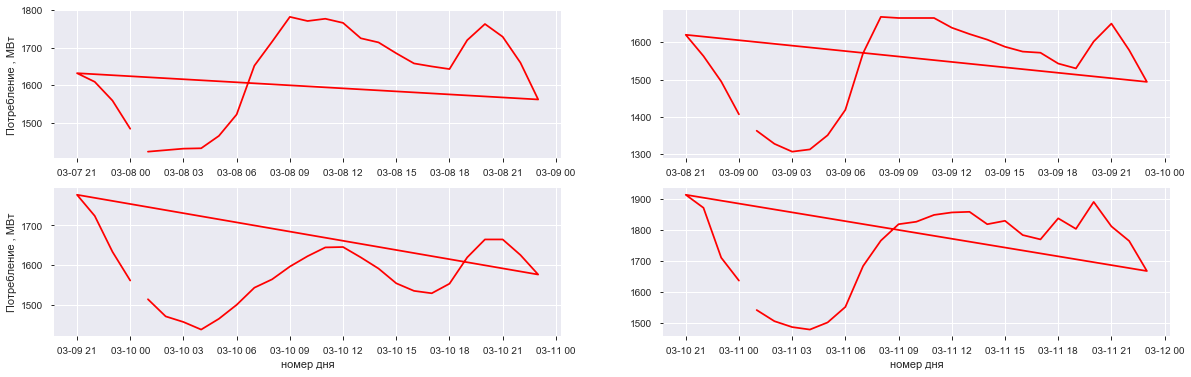

In [36]:
plt.figure(figsize=(20,6))
plt.subplot(2,2,1)
plt.plot(data['2010-03-07 21:00:00':'2010-03-8 23:00:00'].index,data['2010-03-07 21:00:00':'2010-03-08 23:00:00']['DUQ_MW'].values, 'r')
plt.ylabel('Потребление , МВт')

plt.subplot(2,2,2)
plt.plot(data['2015-03-08 21:00:00':'2015-03-9 23:00:00'].index,data['2015-03-08 21:00:00':'2015-03-09 23:00:00']['DUQ_MW'].values, 'r')

plt.subplot(2,2,3)
plt.plot(data['2012-03-09 21:00:00':'2012-03-10 23:00:00'].index,data['2012-03-09 21:00:00':'2012-03-10 23:00:00']['DUQ_MW'].values, 'r')
plt.ylabel('Потребление , МВт')
plt.xlabel('номер дня')

plt.subplot(2,2,4)
plt.plot(data['2005-03-10 21:00:00':'2005-03-11 23:00:00'].index,data['2005-03-10 21:00:00':'2005-03-11 23:00:00']['DUQ_MW'].values, 'r')
plt.xlabel('номер дня')

plt.show()

Результат ревизии нескольких дней показывает, что это постоянная картина для всего ряда. Причина в реверсивном способе дописывания дневных данных

In [37]:
data.iloc[19:26,:]

,DUQ_MW,date
2005-12-31 20:00:00,1737.0,2005-12-31 20:00:00
2005-12-31 21:00:00,1726.0,2005-12-31 21:00:00
2005-12-31 22:00:00,1669.0,2005-12-31 22:00:00
2005-12-31 23:00:00,1592.0,2005-12-31 23:00:00
2006-01-01 00:00:00,1493.0,2006-01-01 00:00:00
2005-12-30 01:00:00,1484.0,2005-12-30 01:00:00
2005-12-30 02:00:00,1419.0,2005-12-30 02:00:00


Данные от 2006-01-01 00:00:00 записаны между 31.12.2005 и 30.12.2005. Принципиально при оценке статистики это не очень страшно, но порядок передачи информации важен, когда мы начинаем рассматривать данные по порядку записи и отображать их на график. Для исключения нарушения порядка проведем сортировку по индексу время-дата. 

In [38]:
data = data.sort_index()

In [39]:
data.iloc[19:26,:]

,DUQ_MW,date
2005-01-01 20:00:00,1546.0,2005-01-01 20:00:00
2005-01-01 21:00:00,1541.0,2005-01-01 21:00:00
2005-01-01 22:00:00,1534.0,2005-01-01 22:00:00
2005-01-01 23:00:00,1497.0,2005-01-01 23:00:00
2005-01-02 00:00:00,1389.0,2005-01-02 00:00:00
2005-01-02 01:00:00,1251.0,2005-01-02 01:00:00
2005-01-02 02:00:00,1204.0,2005-01-02 02:00:00


Теперь навели порядок в данных и посмотрим на них еще раз

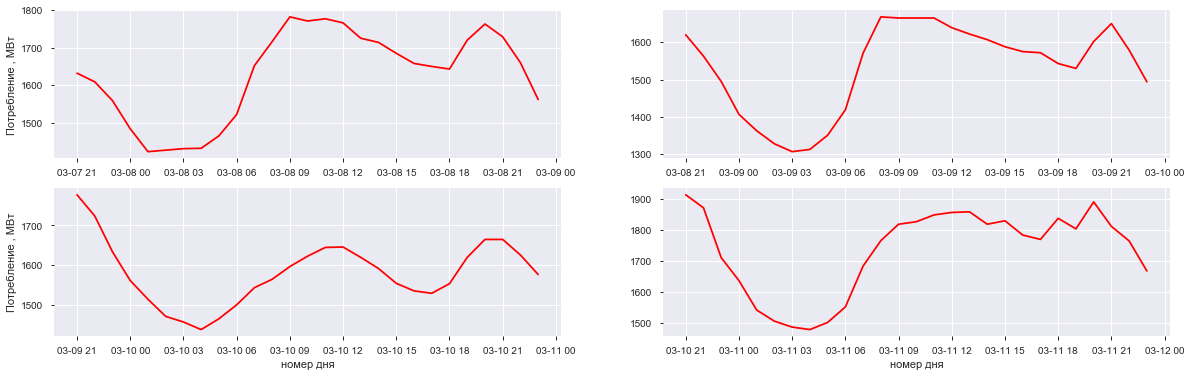

In [40]:
plt.figure(figsize=(20,6))
plt.subplot(2,2,1)
plt.plot(data['2010-03-07 21:00:00':'2010-03-8 23:00:00'].index,data['2010-03-07 21:00:00':'2010-03-08 23:00:00']['DUQ_MW'].values, 'r')
plt.ylabel('Потребление , МВт')

plt.subplot(2,2,2)
plt.plot(data['2015-03-08 21:00:00':'2015-03-9 23:00:00'].index,data['2015-03-08 21:00:00':'2015-03-09 23:00:00']['DUQ_MW'].values, 'r')

plt.subplot(2,2,3)
plt.plot(data['2012-03-09 21:00:00':'2012-03-10 23:00:00'].index,data['2012-03-09 21:00:00':'2012-03-10 23:00:00']['DUQ_MW'].values, 'r')
plt.ylabel('Потребление , МВт')
plt.xlabel('номер дня')

plt.subplot(2,2,4)
plt.plot(data['2005-03-10 21:00:00':'2005-03-11 23:00:00'].index,data['2005-03-10 21:00:00':'2005-03-11 23:00:00']['DUQ_MW'].values, 'r')
plt.xlabel('номер дня')

plt.show()

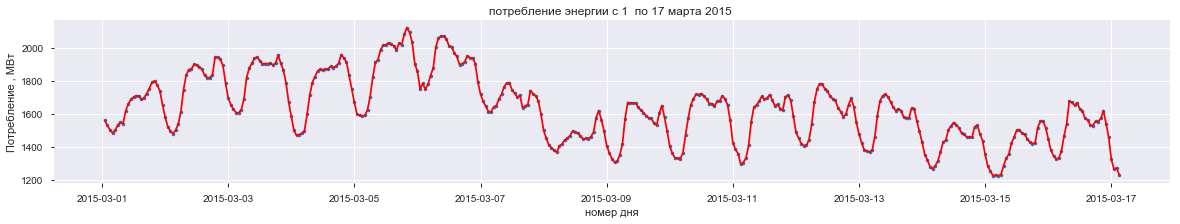

In [41]:
plt.figure(figsize=(20,3))
plt.plot(data['2015-03-01 01:00:00':'2015-03-17 03:00:00'].index,data['2015-03-01 01:00:00':'2015-03-17 03:00:00']['DUQ_MW'].values, '.')
plt.plot(data['2015-03-01 01:00:00':'2015-03-17 03:00:00'].index,data['2015-03-01 01:00:00':'2015-03-17 03:00:00']['DUQ_MW'].values, 'r')

plt.xlabel('номер дня')
plt.ylabel('Потребление , МВт')
plt.title('потребление энергии с 1  по 17 марта 2015 ')
plt.show()

Итак:
     - ряд исправлен,
     - все дни и часы заполнены.

Данный ряд очень похож на ряд, рассмотренный на вебинаре, что неудивительно, т.к. описывает одинаковые процессы. 

Похожая сезонность, и прочие циклы.

Разлмчия - немного меньшая длина ряда и отсутсвие с ходу бросающихся в глаза выбросов).

Недостатки и особенности ряда также похожи на рассмотренный на уроке (пропуски и повторы из-за, вероятно, смены времени, изначально не совсем по порядку идущие данные и пр.).



3. Прочитайте базу Brent и сделайте ее перерасчет (ресемплинг) в представление по неделям , по месяцам . Постройте график изменения среднего по выборке и среднего отклонения по выборке на недельных, месячных и годовых группах для Brent. (одна группа на интервале - одно значение std или mean, т.е. если было 28 деней, то 9 значений для ресемплинга на 3 дня, 4 значения при ресемплинге неделя и 2 значения при ресемплинге 2 недели )

4. Сделайте вывод о том, как изменилось поведение цены на недельных и месячных графиках по сравнению с дневными.

In [187]:
brent_data = pd.read_excel('нефть-brent 2010-2019.xlsx', index_col=[0], parse_dates=[0])
brent_data.head()

,Значение
Дата,
2019-09-01,58.84
2019-08-30,59.19
2019-08-29,60.37
2019-08-28,59.84
2019-08-27,59.59


In [188]:
brent_data  = brent_data.sort_index()

In [192]:
brent_data.head(10)

,Значение
Дата,
2010-09-01,76.37
2010-09-02,76.89
2010-09-03,76.57
2010-09-04,76.62
2010-09-05,76.63
2010-09-06,76.87
2010-09-07,77.26
2010-09-08,77.93
2010-09-09,77.21


In [189]:
brent_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2667 entries, 2010-09-01 to 2019-09-01
Data columns (total 1 columns):
Значение    2667 non-null float64
dtypes: float64(1)
memory usage: 41.7 KB


In [190]:
brent_data.describe()

,Значение
count,2667.000000
mean,81.533547
std,26.349469
min,27.850000
25%,56.840000
50%,77.710000
75%,108.190000
max,126.900000


In [191]:
brent_data[brent_data['Значение'].isnull()].count()

Значение    0
dtype: int64

In [180]:
brent_data_M = brent_data.resample("M").mean()
brent_data_M.head(10)

,Значение
Дата,
2010-09-30,78.228148
2010-10-31,83.473462
2010-11-30,86.178077
2010-12-31,92.232308
2011-01-31,97.033200
2011-02-28,104.451250
2011-03-31,114.811538
2011-04-30,123.197826
2011-05-31,114.345385


In [181]:
brent_data_M.describe()

,Значение
count,109.000000
mean,80.571077
std,26.667645
min,31.984737
25%,57.264074
50%,75.704800
75%,108.559167
max,124.502308


In [182]:
brent_data_W = brent_data.resample("W").mean()
brent_data_W.head()

,Значение
Дата,
2010-09-05,76.616000
2010-09-12,77.673333
2010-09-19,78.693333
2010-09-26,78.518333
2010-10-03,81.211667


In [183]:
brent_data_W.describe()

,Значение
count,469.000000
mean,80.712938
std,26.661299
min,28.690000
25%,56.206000
50%,76.601667
75%,108.114000
max,125.006667


In [185]:
brent_data_Y = brent_data.resample("Y").mean()
brent_data_Y.head()

,Значение
Дата,
2010-12-31,84.963238
2011-12-31,110.758746
2012-12-31,111.377484
2013-12-31,108.137114
2014-12-31,99.435493


In [186]:
brent_data_Y.describe()

,Значение
count,10.000000
mean,80.528219
std,25.682467
min,45.350502
25%,57.270019
50%,78.307329
75%,105.961709
max,111.377484


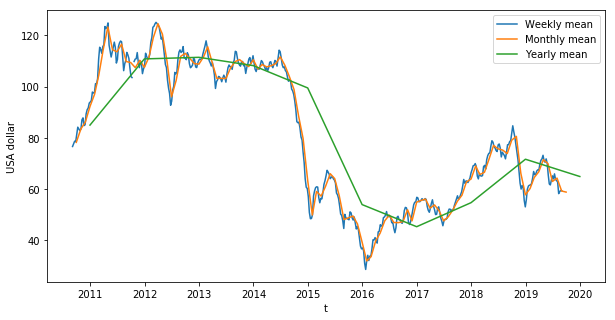

In [200]:
# _ = brent_data['Значение'].plot( style='.', figsize=( 15, 7 ), title='Brent ')
plt.figure(figsize=(10, 5))
plt.plot(brent_data_W, label='Weekly mean')
plt.plot(brent_data_M, label='Monthly mean')
plt.plot(brent_data_Y, label='Yearly mean')

plt.ylabel('USA dollar')
plt.xlabel('t')
plt.legend()
plt.show()

In [202]:
brent_data_W_std = brent_data.resample("W").std()
brent_data_W_std.head()

,Значение
Дата,
2010-09-05,0.185688
2010-09-12,0.649759
2010-09-19,0.539728
2010-09-26,0.596068
2010-10-03,2.408588


In [205]:
brent_data_W_std_M = brent_data_W_std.resample("M").mean()
brent_data_W_std_M.head()

,Значение
Дата,
2010-09-30,0.492811
2010-10-31,1.089151
2010-11-30,1.325877
2010-12-31,0.903806
2011-01-31,0.954304


In [206]:
brent_data_W_std_Y = brent_data_W_std.resample("Y").mean()
brent_data_W_std_Y.head()

,Значение
Дата,
2010-12-31,0.960925
2011-12-31,1.692663
2012-12-31,1.316001
2013-12-31,1.030242
2014-12-31,0.947655


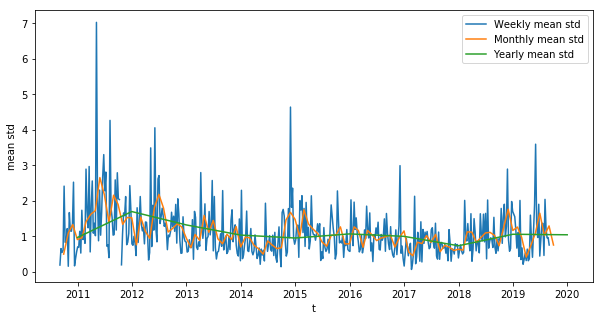

In [207]:
plt.figure(figsize=(10, 5))
plt.plot(brent_data_W_std, label='Weekly mean std')
plt.plot(brent_data_W_std_M, label='Monthly mean std')
plt.plot(brent_data_W_std_Y, label='Yearly mean std')

plt.ylabel('mean std')
plt.xlabel('t')
plt.legend()
plt.show()

5. Графики становятся более "плавные" со временем, т.е. чем больше период, за который снимаются данные, тем лучше видно "развитие" данных во времени, снижается влияние краткосрочных "скачков"